In [1]:
import pathlib
import re
import types
import warnings

import pandas as pd

BELLS = {'de': {'url': 'https://de.wikipedia.org/wiki/Liste_von_Glocken_in_Deutschland',
                'index_col':'Name:'},
         'ch': {'url': 'https://de.wikipedia.org/wiki/Liste_der_gr%C3%B6ssten_Glocken_der_Schweiz',
                'index_col': 'Name'}}

ENCODING = 'utf-8'


def iterdataframes(encoding=ENCODING):
    for cc, bell in BELLS.items():
        path = pathlib.Path(f'bells_{cc}.csv')
        if not path.exists():
            df, = pd.read_html(bell['url'], index_col=bell['index_col'])
            df.to_csv(path, encoding=encoding)

        yield cc, pd.read_csv(path, encoding=encoding, index_col=bell['index_col'])


df = types.SimpleNamespace(**dict(iterdataframes()))

for x in (df.de, df.ch):
    x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440 entries, Petersglocke(im Volksmund Decke Pitter, Dicker Pitter) to Katharinaglocke
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nr:               440 non-null    float64
 1   Bild:             1 non-null      object 
 2   Gebäude           440 non-null    object 
 3   Standort          440 non-null    object 
 4   Bundesland        440 non-null    object 
 5   Ton:              440 non-null    object 
 6   Masse (kg)        440 non-null    object 
 7   Ø (mm)            430 non-null    object 
 8   Jahr:             440 non-null    int64  
 9   Gießer: Gussort:  440 non-null    object 
 10  Werkstoff:        440 non-null    object 
 11  Konf.:            424 non-null    object 
 12  Bemerkungen       44 non-null     object 
dtypes: float64(1), int64(1), object(11)
memory usage: 48.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, Grosse Gl

In [2]:
NOTES = tuple(n + s for n in 'CDEFGAB' for s in ('',  '#')
              if n + s not in ('E#', 'B#'))

assert len(NOTES) == 12

MIDI_NOTES = tuple(f'{n}{o}' for o in range(-1, 10) for n in NOTES
                   if f'{n}{o}' not in ('G#9', 'A9', 'A#9', 'B9'))

assert len(MIDI_NOTES) == 128

MIDI_NOTES[:5]

('C-1', 'C#-1', 'D-1', 'D#-1', 'E-1')

In [3]:
def iterenharmonic(base='abcdefg',sep='_', sharp='#', include_all=True):
    for b in base:
        yield b, b.upper()
        if include_all or b not in 'be':
            yield f'{b}{sep}sharp', b[0].upper() + sharp

    for b, e in zip(base, base[-1] + base[:-1]):
        if include_all or b not in 'cf':
            yield f'{b}{sep}flat', e.upper() + sharp

    yield 'h', 'B'

CANONICAL = dict(iterenharmonic())


pd.Series(CANONICAL).to_frame('canonical')

,canonical
a,A
a_sharp,A#
b,B
b_sharp,B#
c,C
c_sharp,C#
d,D
d_sharp,D#
e,E
e_sharp,E#


<ipython-input-4-e672139c4768>:32: UserWarning: missed: ['fº', 'h0/c1']
  warnings.warn(f'missed: {missed}')


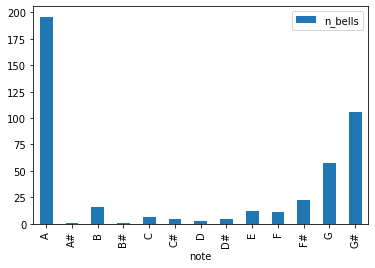

In [4]:
PARSE_NOTE = re.compile(
    r'(?P<base>[a-h])'
      r'(?:'
          r"(?P<sharp>is|'|º)"
          r'|'
          r'(?P<flat>es|s)'
      r')?'
      r'[ \u00a0]?'
      r'(?P<octave>-1|[0-9])'
      r'(?:'
          r'(?:'
              r'[ \u00a0]?'
              r'(?:'
                  r'(?P<pos>[+/])'
                  r'|'
                  r'(?P<neg>[-\u2013\u2212])'
              r')'
              r'(?P<div>1[0-6]|[1-9])'
              r'(?:/16)?'
          r')?'
      r')?'
     r'(?:,.*)?')


def iternotes(series, verbose=False, sep='_'):
    if verbose:
        print(*sorted(series), sep='|')

    missed = (~series.str.fullmatch(PARSE_NOTE)).sum()
    if missed:
        missed = series[~series.str.fullmatch(PARSE_NOTE)].tolist()
        warnings.warn(f'missed: {missed}')

    matches = series.str.extract(PARSE_NOTE).fillna('')
    for _, base, sharp, flat, octave, pos, neg, div in matches.itertuples(name=None):
        if not octave:
            yield None
            continue

        suffix = f'{sep}sharp' if sharp else f'{sep}flat' if flat else ''
        note = f'{base}{suffix}{sep}{int(octave)}'
        if div:
            sign = '+' if pos or not neg else '-'
            note += f'{sep}{int(sign + div)}'

        yield CANONICAL[f'{base}{suffix}']


nf = df.de['Ton:'].value_counts().to_frame('n_bells')
nf['note'] = list(iternotes(nf.index.to_series()))

cf = nf.groupby('note')['n_bells'].sum().to_frame('n_bells')
cf.plot.bar();

<ipython-input-4-e672139c4768>:32: UserWarning: missed: ['g0[3]']
  warnings.warn(f'missed: {missed}')


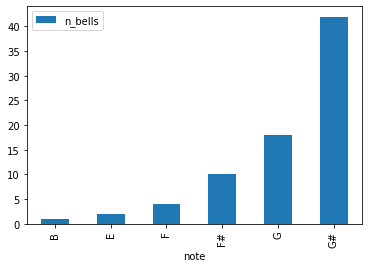

In [5]:
nf = df.ch['Schlagton (HT-1/16)'].value_counts().to_frame('n_bells')
nf['note'] = list(iternotes(nf.index.to_series()))

cf = nf.groupby('note')['n_bells'].sum().to_frame('n_bells')
cf.plot.bar();